In [2]:
import os
import pickle
import numpy as np

def load_cifar10_data(filename):
    with open('../input/cifar10/'+ filename, 'rb') as file:
        batch = pickle.load(file, encoding='latin1')

    #test = batch['input']
    #unfat = batch['labels']
    #return features, input

    features = batch['data']
    labels = batch['labels']
    return features, labels

# Load files
batch_1, labels_1 = load_cifar10_data('data_batch_1')
batch_2, labels_2 = load_cifar10_data('data_batch_2')
batch_3, labels_3 = load_cifar10_data('data_batch_3')
batch_4, labels_4 = load_cifar10_data('data_batch_4')
batch_5, labels_5 = load_cifar10_data('data_batch_5')

X_test, y_test = load_cifar10_data('test_batch')

# Merge files
X_train = np.concatenate([batch_1,batch_2,batch_3,batch_4,batch_5], 0)
y_train = np.concatenate([labels_1,labels_2,labels_3,labels_4,labels_5], 0)
y_test = np.array(y_test)

In [3]:
print(X_train.shape)
print(X_test.shape)

(50000, 3072)
(10000, 3072)


In [4]:

import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [5]:

#X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

def data_reshape(file):
    assert file.shape[1] == 3072
    dim = np.sqrt(1024).astype(int)
    r = file[:, 0:1024].reshape(file.shape[0], dim, dim, 1)
    g = file[:, 1024:2048].reshape(file.shape[0], dim, dim, 1)
    b = file[:, 2048:3072].reshape(file.shape[0], dim, dim, 1)
    return np.concatenate([r,g,b], -1)

X_train = data_reshape(X_train)
X_test = data_reshape(X_test)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [7]:

num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [8]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [9]:
#import the utils
!cp -r ../input/knn-util/* ./
from k_nearest_neighbor import KNearestNeighbor


In [10]:

classifier = KNearestNeighbor()
classifier.train(X_train/255.0, y_train)

In [11]:

# Test implementation:
dists = classifier.compute_distances_two_loops(X_test/255.0)
print(dists.shape)

(500, 5000)


In [13]:

y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [ ]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

In [ ]:

dists_two = classifier.compute_distances_no_loops(X_test/255.0)
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

In [ ]:

def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test/255.0)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test/255.0)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test/255.0)
print('No loop version took %f seconds' % no_loop_time)


### Cross-validation

In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
X_train_folds = np.array_split(X_train/255.0, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies = {}

for k in k_choices:
    k_acc = []
    for i in range(num_folds):
        X_train_fold = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])
        y_train_fold = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])
        X_val_fold = X_train_folds[i]
        y_val_fold = y_train_folds[i]
        
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold/255.0, y_train_fold)
        dists_fold = classifier.compute_distances_no_loops(X_val_fold/255.0)
        
        y_val_pred = classifier.predict_labels(dists_fold, k)
        num_correct = np.sum(y_val_pred == y_val_fold)
        accuracy = float(num_correct) / y_val_fold.shape[0]
        k_acc.append(accuracy)
    k_to_accuracies[k] = k_acc

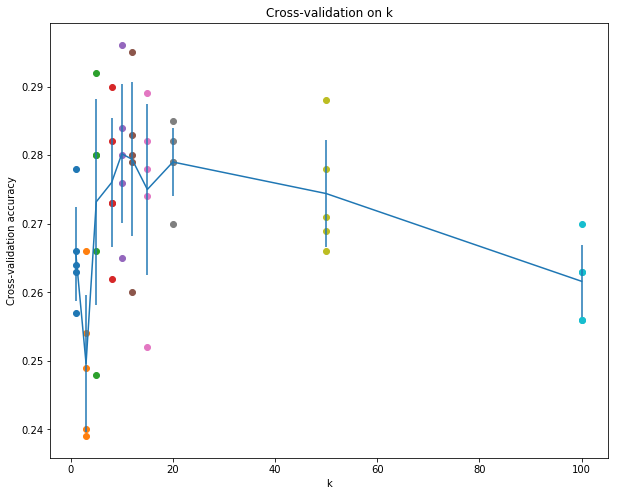

In [19]:

for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()